In [1]:
import numpy as np
import pandas as pd
import ast
import gensim
import matplotlib.pyplot as plt

# APNews Model Test

In [21]:
apnews_model = gensim.models.Doc2Vec.load('apnews_sen_model.model')

In [22]:
test_sentence = ["Kabir", "is", "my", "name"]
test_sentence_2 = ["Kabir", "is", "my", "dog's", "name"]
test_sentence_3 = ["Michael", "cheats", "on", "his", "diet"]
test_sentence_4 = ["Abraham", "Lincoln", "has", "had", "better", "days"]
print(apnews_model.docvecs.similarity_unseen_docs(apnews_model, test_sentence, test_sentence))
print(apnews_model.docvecs.similarity_unseen_docs(apnews_model, test_sentence, test_sentence_2))
print(apnews_model.docvecs.similarity_unseen_docs(apnews_model, test_sentence, test_sentence_3))
print(apnews_model.docvecs.similarity_unseen_docs(apnews_model, test_sentence, test_sentence_4))

0.897589518908
0.881390253871
0.890048865768
0.892078232341


# Wikipedia Model Test

In [23]:
wiki_model = gensim.models.Doc2Vec.load('wiki_model.model')

In [29]:
test_sentence = ["Kabir", "is", "my", "name"]
test_sentence_2 = ["Kabir", "is", "my", "dog's", "name"]
test_sentence_3 = ["Michael", "cheats", "on", "his", "diet"]
test_sentence_4 = ["Abraham", "Lincoln", "has", "had", "better", "days"]
print(apnews_model.docvecs.similarity_unseen_docs(wiki_model, test_sentence, test_sentence))
print(apnews_model.docvecs.similarity_unseen_docs(wiki_model, test_sentence, test_sentence_2))
print(apnews_model.docvecs.similarity_unseen_docs(wiki_model, test_sentence, test_sentence_3))
print(apnews_model.docvecs.similarity_unseen_docs(wiki_model, test_sentence, test_sentence_4))

0.724653828452
0.871757108945
0.124214567341
-0.156156735423


## Reduce Model RAM

In [31]:
wiki_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
wiki_model.save('wiki_model_reduced.model')

In [32]:
apnews_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
apnews_model.save('apnews_model_reduced.model')

## Load RAM Reduced Models

In [33]:
wiki_model_reduced = gensim.models.Doc2Vec.load('wiki_model_reduced.model')
apnews_model_reduced = gensim.models.Doc2Vec.load('apnews_model_reduced.model')

 ## Retest to make sure RAM reduce had no negative effects

In [40]:
test_sentence = ["Kabir", "is", "my", "name"]
test_sentence_2 = ["Kabir", "is", "my", "dog's", "name"]
test_sentence_3 = ["Michael", "cheats", "on", "his", "diet"]
test_sentence_4 = ["Abraham", "Lincoln", "has", "had", "better", "days"]
print(apnews_model_reduced.docvecs.similarity_unseen_docs(apnews_model_reduced, test_sentence, test_sentence))
print(apnews_model_reduced.docvecs.similarity_unseen_docs(apnews_model_reduced, test_sentence, test_sentence_2))
print(apnews_model_reduced.docvecs.similarity_unseen_docs(apnews_model_reduced, test_sentence, test_sentence_3))
print(apnews_model_reduced.docvecs.similarity_unseen_docs(apnews_model_reduced, test_sentence, test_sentence_4))

0.905292815112
0.727345367884
0.91559562846
0.785478510041


In [45]:
test_sentence = ["Kabir", "is", "my", "name"]
test_sentence_2 = ["Kabir", "is", "my", "dog's", "name"]
test_sentence_3 = ["Michael", "cheats", "on", "his", "diet"]
test_sentence_4 = ["Abraham", "Lincoln", "has", "had", "better", "days"]
print(wiki_model_reduced.docvecs.similarity_unseen_docs(wiki_model_reduced, test_sentence, test_sentence))
print(wiki_model_reduced.docvecs.similarity_unseen_docs(wiki_model_reduced, test_sentence, test_sentence_2))
print(wiki_model_reduced.docvecs.similarity_unseen_docs(wiki_model_reduced, test_sentence, test_sentence_3))
print(wiki_model_reduced.docvecs.similarity_unseen_docs(wiki_model_reduced, test_sentence, test_sentence_4))

0.82072526216
0.770262920605
0.405964176383
-0.463152806387


# Wikipedia Data

In [46]:
df = pd.read_csv('wiki_summaries.csv')
df_2 = pd.read_csv('wiki_documents.csv')

wiki_summaries = df['Summaries']
tokenized_wiki_summaries = [ast.literal_eval(summary) for summary in df['Tokenized Summaries']]
wiki_documents = df_2['Documents']
tokenized_wiki_documents = [ast.literal_eval(document) for document in df_2['Tokenized Documents']]
titles = df['Titles']

In [47]:
wiki_summary_lengths = {}
for i in range(len(tokenized_wiki_summaries)):
    summ_length = len(tokenized_wiki_summaries[i])
    if summ_length in wiki_summary_lengths:
        wiki_summary_lengths[summ_length].append(i)
    else:
        wiki_summary_lengths[summ_length] = [i]

In [48]:
def plot_average_summary_similarity(batch_summaries, batch_documents, model):
    print(str(len(batch_summaries)) + ' summaries containing ' + str(len(batch_summaries[0])) + ' sentences.')
    
    sentence_similarities = {}
    total_num_sentences = 0
    for id in range(len(batch_summaries)):
        summ = batch_summaries[id]
        doc = batch_documents[id]
        
        for i in range(len(summ)):
            summ_sent = summ[i]
            for doc_sent in doc:
                similarity = model.docvecs.similarity_unseen_docs(model, summ_sent.split(" "), doc_sent.split(" "))
                if i in sentence_similarities:
                    sentence_similarities[i] += similarity
                else:
                    sentence_similarities[i] = similarity

        total_num_sentences += len(doc)
            
    for sen_num in sentence_similarities:
        sentence_similarities[sen_num] /= total_num_sentences
    
    summ_sentences = list(sentence_similarities.keys())
    sims = [sentence_similarities[sent] for sent in sentence_similarities]
    
    plt.bar(np.arange(len(summ_sentences)), sims)
    plt.ylabel('Average Similarity in Document')
    plt.xlabel('Sentence Number in Summary')
    plt.xticks(np.arange(len(summ_sentences)))

In [49]:
def compute_summary_similarities(tokenized_summaries, num_summary_sentences, threshold, model, summary_lengths):
    similarities = np.zeros(shape=(int(num_summary_sentences), int(num_summary_sentences)))
    filtered_summary_ids = summary_lengths[num_summary_sentences]

    for summ_id in filtered_summary_ids:
        tok_summary = tokenized_summaries[summ_id]
        for i in range(len(tok_summary)):
            for j in range(len(tok_summary)):
                similarity = model.docvecs.similarity_unseen_docs(model, tok_summary[i].split(" "), tok_summary[j].split(" "))
                if similarity > threshold:
                    similarities[i][j] += 1

    num_summs = len(filtered_summary_ids)
    for i in range(int(num_summary_sentences)):
        for j in range(int(num_summary_sentences)):
            similarities[i][j] /= num_summs

    return similarities

20 summaries containing 5 sentences.


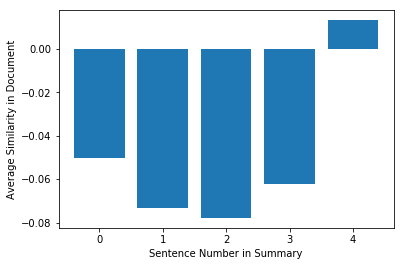

In [50]:
doc_ids = wiki_summary_lengths[5]
batch_documents = [tokenized_wiki_documents[doc_id] for doc_id in doc_ids]
batch_summaries = [tokenized_wiki_summaries[doc_id] for doc_id in doc_ids]

plot_average_summary_similarity(batch_summaries[0:20], batch_documents[0:20], apnews_model_reduced)

In [51]:
print(compute_summary_similarities(tokenized_wiki_summaries, 5, .70, apnews_model_reduced, wiki_summary_lengths))

[[ 0.21428571  0.00132275  0.00529101  0.00925926  0.00661376]
 [ 0.00396825  0.17857143  0.00529101  0.0026455   0.0026455 ]
 [ 0.0026455   0.00132275  0.18783069  0.00661376  0.00396825]
 [ 0.0026455   0.0026455   0.00132275  0.1984127   0.00529101]
 [ 0.00529101  0.00396825  0.00132275  0.          0.21164021]]
